# Importing Libraries

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import pylab
from pycbc.filter import resample_to_delta_t, highpass, matched_filter, sigma
from pycbc.frame import read_frame
from pycbc.waveform import get_td_waveform
from pycbc.psd import interpolate, inverse_spectrum_truncation
import numpy
import pandas as pd

# Read the data frame

In [2]:
strain = read_frame('det2.gwf',channels=['V1:FAKE_STRAIN'])[0]

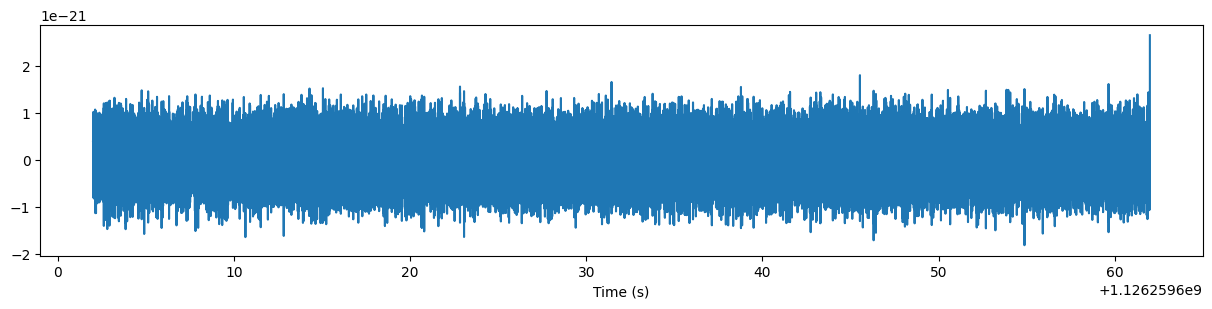

In [3]:
# Remove the low frequency content and downsample the data to 2048Hz
strain = highpass(strain, 50.0)
strain = resample_to_delta_t(strain, 1.0/2048)
pylab.figure(figsize=[15, 3])
pylab.plot(strain.sample_times, strain)
pylab.xlabel('Time (s)')
pylab.savefig('plots/highpass_strain.png',dpi=300, bbox_inches='tight')
pylab.show()

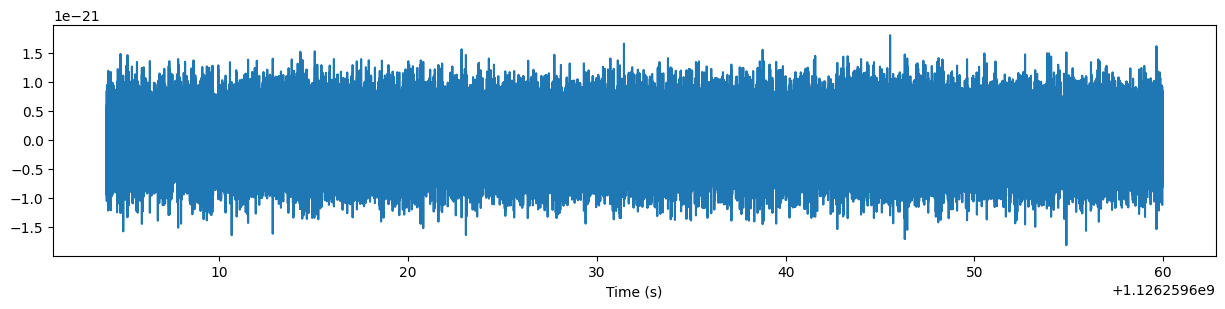

In [4]:
# Remove 2 seconds of data from both the beginning and end
conditioned = strain.crop(2, 2)
pylab.figure(figsize=[15, 3])
pylab.plot(conditioned.sample_times, conditioned)
pylab.xlabel('Time (s)')
pylab.savefig('plots/cropped_strain.png',dpi=300, bbox_inches='tight')
pylab.show()

# Estimate the power spectral density

In [5]:
# We use 4 second samples of our time series in Welch method.
psd = conditioned.psd(4)

# Now that we have the psd we need to interpolate it to match our data
# and then limit the filter length of 1 / PSD. After this, we can
# directly use this PSD to filter the data in a controlled manner
psd = interpolate(psd, conditioned.delta_f)

# 1/PSD will now act as a filter with an effective length of 4 seconds
# Since the data has been highpassed above 15 Hz, and will have low values
# below this we need to inform the function to not include frequencies
# below this frequency. 
psd = inverse_spectrum_truncation(psd, int(4 * conditioned.sample_rate),
                                  low_frequency_cutoff=50)

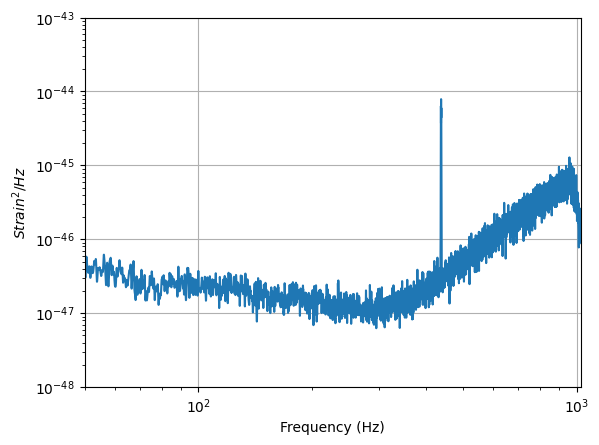

In [6]:
# Note that the psd is a FrequencySeries!
pylab.loglog(psd.sample_frequencies, psd)
    
pylab.ylabel('$Strain^2 / Hz$')
pylab.xlabel('Frequency (Hz)')
pylab.grid()
pylab.xlim(50, 1024)
pylab.ylim(1e-48, 1e-43)
pylab.savefig('plots/psd.png',dpi=300, bbox_inches='tight')
pylab.show()

# Whiten the data

In [7]:
# This produces a whitened set.
# This works by estimating the power spectral density from the
# data and then flattening the frequency response.
# (1) The first option sets the duration in seconds of each
#     sample of the data used as part of the PSD estimate.
# (2) The second option sets the duration of the filter to apply
whitened = conditioned.whiten(4, 4)

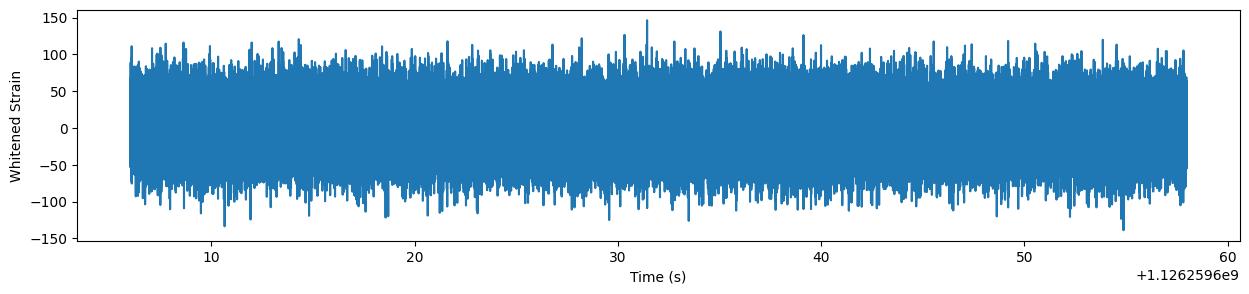

In [8]:
pylab.figure(figsize=[15, 3])
pylab.plot(whitened.sample_times, whitened)
pylab.ylabel('Whitened Strain')
pylab.xlabel('Time (s)')
pylab.savefig('plots/whitened_strain.png',dpi=300, bbox_inches='tight')
pylab.show()

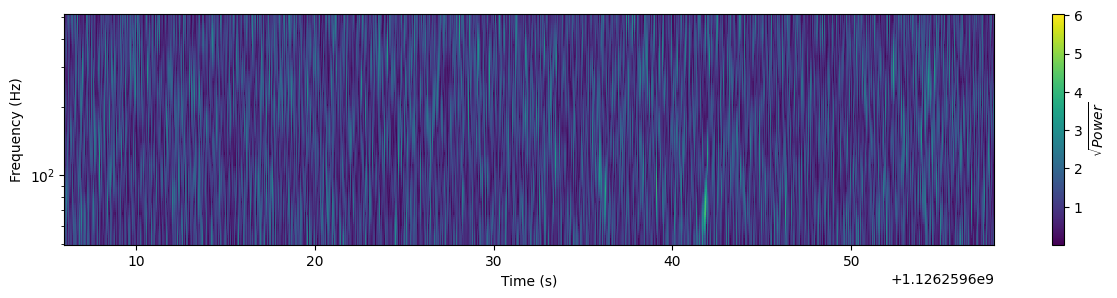

In [9]:
# The qtransform method returns a vector of the sample times, frequencies, and a 2-d vector of the 
# power in each time-frequency bin. The free parameter is the choice of the Q-value. Larger Q-values
# are generally more appropriate for viewing long duration features of the data and vice versa. 
                
# The options here:
# (1) The time spacing for the output image (i.e. 1 ms in this case)
# (2) The number of frequency bins in the output, logarithmically spaced
# (3) The qrange to maximize over. We'll pick a constant at 8 here
#     Typically higher values will be more appropriate for longer duration
#     signals
# (4) The frequency range to output
times, freqs, power = whitened.qtransform(.001, logfsteps=100,
                                            qrange=(8, 8),
                                            frange=(50, 512),
                                        )
pylab.figure(figsize=[15, 3])
pylab.pcolormesh(times, freqs, power**0.5)
# pylab.xlim(m_time - 0.5, m_time + 0.3)
pylab.yscale('log')
pylab.xlabel('Time (s)')
pylab.ylabel('Frequency (Hz)')
pylab.colorbar(label='$\\sqrt{Power}$')
pylab.savefig('plots/qtransform.png',dpi=300, bbox_inches='tight')
pylab.show()

# Enhance! Zoom to the signal in the data

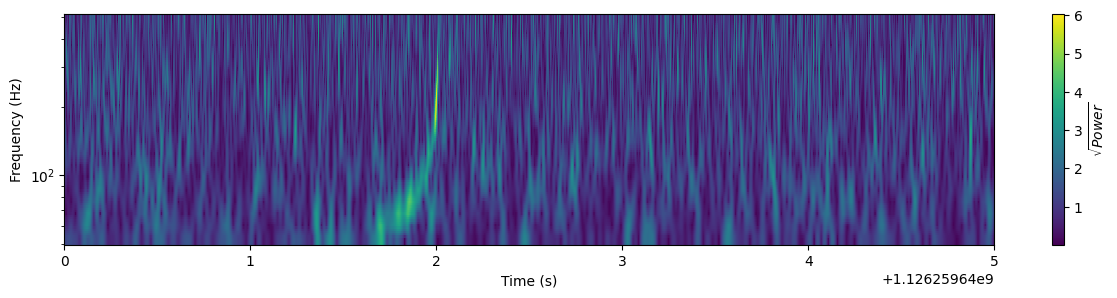

In [10]:
pylab.figure(figsize=[15, 3])
pylab.pcolormesh(times, freqs, power**0.5)
pylab.xlim(1126259640, 1126259645)
pylab.yscale('log')
pylab.xlabel('Time (s)')
pylab.ylabel('Frequency (Hz)')
pylab.colorbar(label='$\\sqrt{Power}$')
pylab.savefig('plots/qtransform_zoomed.png',dpi=300, bbox_inches='tight')
pylab.show()

# Its clearer now! One final push!

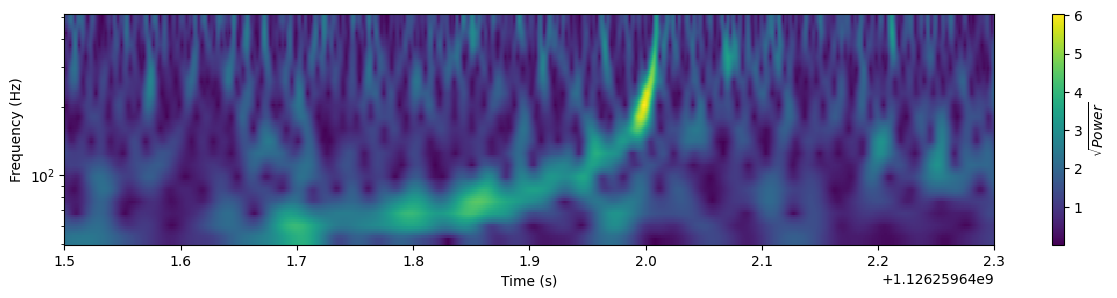

In [11]:
m_time = 1126259642.0
pylab.figure(figsize=[15, 3])
pylab.pcolormesh(times, freqs, power**0.5)
pylab.xlim(m_time - 0.5, m_time + 0.3)
pylab.yscale('log')
pylab.xlabel('Time (s)')
pylab.ylabel('Frequency (Hz)')
pylab.colorbar(label='$\\sqrt{Power}$')
pylab.savefig('plots/qtransform_zoomed2.png',dpi=300, bbox_inches='tight')
pylab.show()

# Searching the parameter space using matched filtering

In [12]:
def search_mass_space(masses,output_file):
    df = []
    for idx1 in range(len(masses)):
        for idx2 in range(idx1, len(masses)):
            m1 = masses[idx2]
            m2 = masses[idx1]
            hp, hc = get_td_waveform(approximant="SEOBNRv4",
                                mass1=m1,
                                mass2=m2,
                                delta_t=conditioned.delta_t,
                                f_lower=50)
            hp.resize(len(conditioned))
            template = hp.cyclic_time_shift(hp.start_time)
            snr = matched_filter(template, conditioned,
                                psd=psd, low_frequency_cutoff=50)
            snr = snr.crop(4 + 4, 4)
            peak = abs(snr).numpy().argmax()
            snrp = snr[peak]
            time = snr.sample_times[peak]
            print("Found a signal at {}s with SNR {}".format(time,abs(snrp)))
            df.append({'mass1': m1, 'mass2': m2, 'time': time, 'snr': abs(snrp)})
    df = pd.DataFrame(df)
    # save to results.csv
    df.to_csv(output_file, index=False)
    return df

def plot_mass_space(df, masses, output_file):
    # use imshow to plot the SNR values with mass1 on the x-axis and mass2 on the y-axis (note only mass2 >= mass1 are valid)
    pylab.figure(figsize=[10, 6])
    pylab.imshow(df.pivot(index='mass2', columns='mass1', values='snr'), aspect='auto', origin='lower')
    pylab.colorbar(label='SNR')
    pylab.xlabel('Mass 1')
    pylab.xticks(range(0, len(masses), 2), ['%.1f' % m for m in masses[::2]], rotation=45)
    pylab.ylabel('Mass 2')
    pylab.yticks(range(0, len(masses), 2), ['%.1f' % m for m in masses[::2]])
    pylab.title('Matched Filter SNR')
    pylab.savefig(output_file,dpi=300, bbox_inches='tight')
    pylab.show()

# Coarse search (from 10 to 100 $M_\odot$)

The highest SNR is 11.25 at time 1126259642.00s with m1=10.00 and m2=10.00


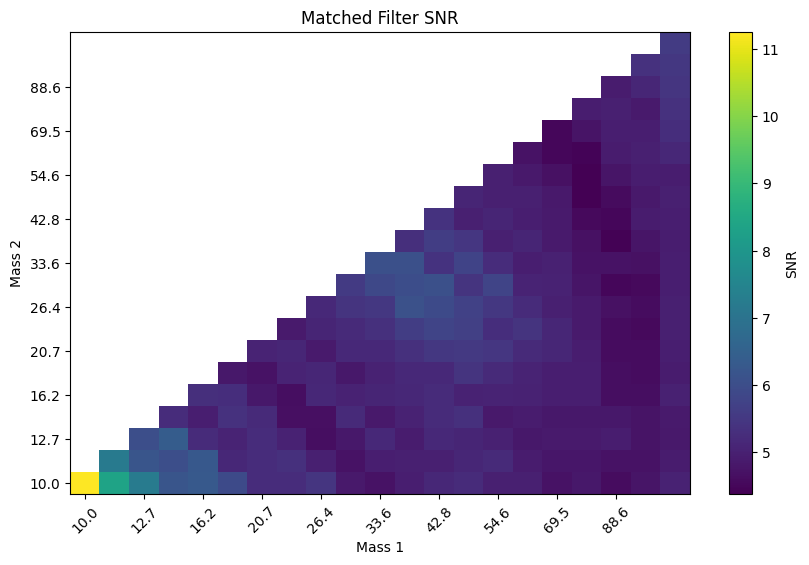

In [13]:
# mass range for typical compact binary systems is 10-100 solar masses
masses_coarse = numpy.logspace(1, 2, 20)
# df_coarse = search_mass_space(numpy.logspace(1, 2, 20), 'results_coarse.csv')
df_coarse = pd.read_csv('results_coarse.csv')
# find the (m1, m2) pair with the highest SNR from df
idx = df_coarse['snr'].idxmax()
m1 = df_coarse.loc[idx, 'mass1']
m2 = df_coarse.loc[idx, 'mass2']
t = df_coarse.loc[idx, 'time']
print(f"The highest SNR is {df_coarse.loc[idx, 'snr']:.2f} at time {t:.2f}s with m1={m1:.2f} and m2={m2:.2f}")
plot_mass_space(df_coarse, masses_coarse, 'plots/mass_space_coarse.png')

# Fine search (from 9 to 11 $M_\odot$)

The highest SNR is 11.53 at time 1126259642.01s with m1=10.10 and m2=9.40


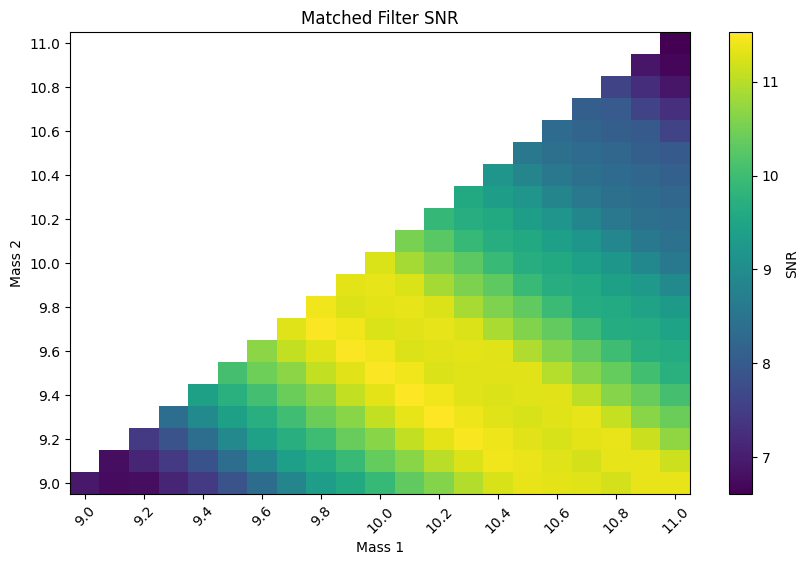

In [14]:
masses_fine = numpy.linspace(9,11,21)
# df_fine = search_mass_space(masses_fine, 'results_fine.csv')
df_fine = pd.read_csv('results_fine.csv')
# find the (m1, m2) pair with the highest SNR from df
idx = df_fine['snr'].idxmax()
m1 = df_fine.loc[idx, 'mass1']
m2 = df_fine.loc[idx, 'mass2']
t = df_fine.loc[idx, 'time']
print(f"The highest SNR is {df_fine.loc[idx, 'snr']:.2f} at time {t:.2f}s with m1={m1:.2f} and m2={m2:.2f}")
plot_mass_space(df_fine, masses_fine, 'plots/mass_space_fine.png')

# Create template for optimal matched filter

In [15]:
hp, hc = get_td_waveform(approximant="SEOBNRv4",
                    mass1=m1,
                    mass2=m2,
                    delta_t=conditioned.delta_t,
                    f_lower=50)
hp.resize(len(conditioned))
template = hp.cyclic_time_shift(hp.start_time)
snr = matched_filter(template, conditioned,
                    psd=psd, low_frequency_cutoff=50)
snr = snr.crop(4 + 4, 4)
peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]

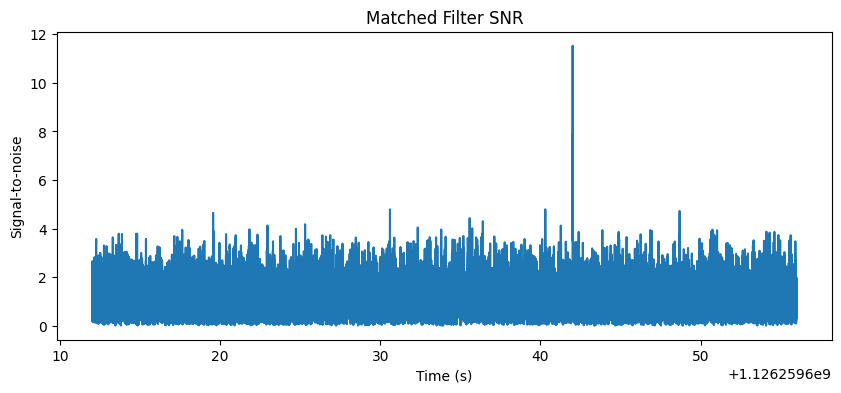

In [16]:
pylab.figure(figsize=[10, 4])
pylab.plot(snr.sample_times, abs(snr))
pylab.ylabel('Signal-to-noise')
pylab.xlabel('Time (s)')
pylab.title('Matched Filter SNR')
pylab.savefig('plots/matched_filter_snr.png',dpi=300, bbox_inches='tight')
pylab.show()

### Aligning and Subtracting the Proposed Signal

In the previous section we found a peak in the signal-to-noise for a proposed binary black hole merger. We can use this SNR peak to align our proposal to the data, and to also subtract our proposal from the data.

In [17]:
# The time, amplitude, and phase of the SNR peak tell us how to align
# our proposed signal with the data.

# Shift the template to the peak time
dt = time - conditioned.start_time
aligned = template.cyclic_time_shift(dt)

# scale the template so that it would have SNR 1 in this data
aligned /= sigma(aligned, psd=psd, low_frequency_cutoff=50.0, high_frequency_cutoff=500.0)

# Scale the template amplitude and phase to the peak value
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries()
aligned.start_time = conditioned.start_time

#### Visualize the overlap between the signal and data

To compare the data an signal on equal footing, and to concentrate on the frequency range that is important. We will whiten both the template and the data, and then bandpass both the data and template between 50-500 Hz. In this way, any signal that is in the data is transformed in the same way that the template is.

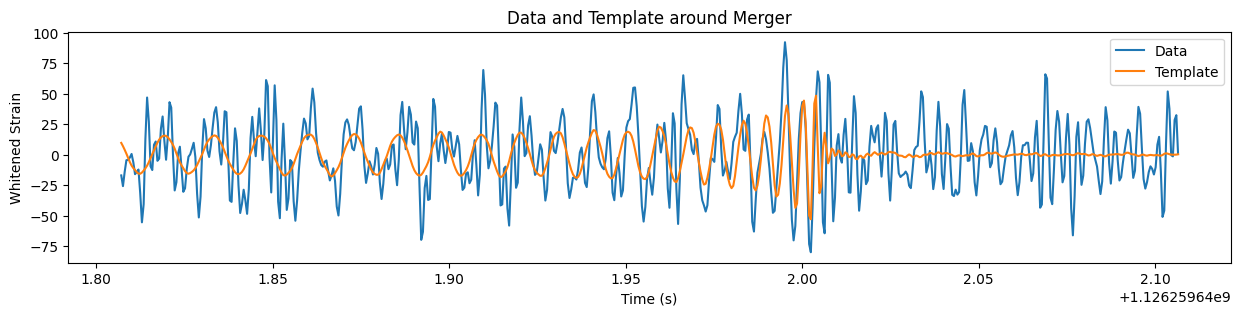

In [18]:
# We do it this way so that we can whiten both the template and the data
white_data = (conditioned.to_frequencyseries() / psd**0.5).to_timeseries()
white_template = (aligned.to_frequencyseries() / psd**0.5).to_timeseries()

white_data = white_data.highpass_fir(50., 512).lowpass_fir(500, 512)
white_template = white_template.highpass_fir(50, 512).lowpass_fir(500, 512)

# Select the time around the merger
white_data = white_data.time_slice(time-.2, time+.1)
white_template = white_template.time_slice(time-.2, time+.1)

pylab.figure(figsize=[15, 3])
pylab.plot(white_data.sample_times, white_data, label="Data")
pylab.plot(white_template.sample_times, white_template, label="Template")
pylab.legend()
pylab.ylabel('Whitened Strain')
pylab.xlabel('Time (s)')
pylab.title('Data and Template around Merger')
pylab.savefig('plots/overlay_data_template.png',dpi=300, bbox_inches='tight')
pylab.show()

#### Subtracting the signal from the data

Now that we've aligned the template we can simply subtract it. Let's see below how that looks in the time-frequency plots!

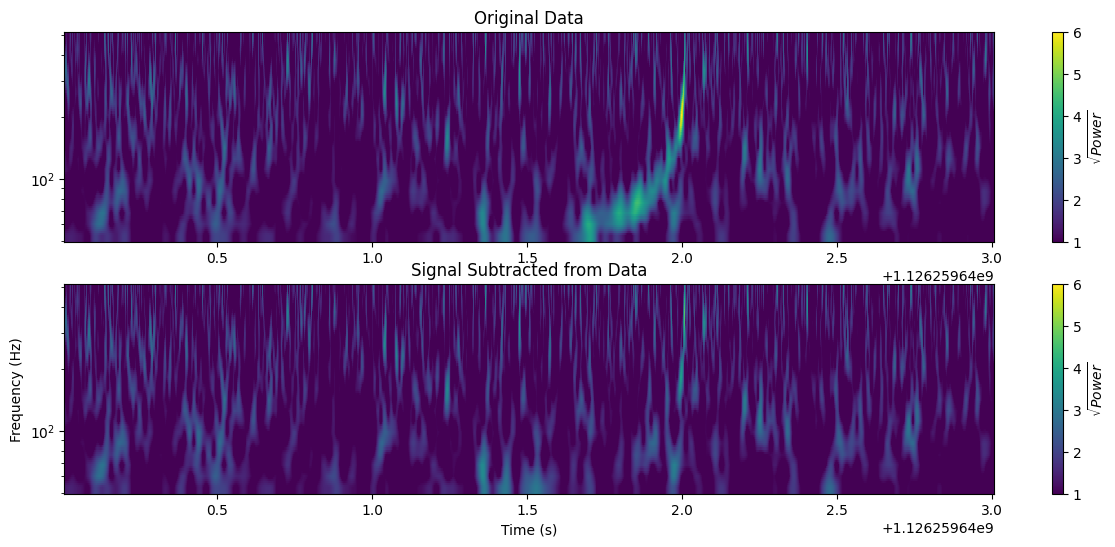

In [19]:
subtracted = conditioned - aligned

# Plot the original data and the subtracted signal data
pylab.figure(figsize=[15, 6])

for i in [1,0]:
    data, title = [(conditioned, 'Original Data'),
                    (subtracted, 'Signal Subtracted from Data')][i]
    t, f, p = data.whiten(4, 4).qtransform(.001,
                                                  logfsteps=100,
                                                  qrange=(8, 8),
                                                  frange=(50, 512))
    if i==1:
        ax = pylab.subplot(2, 1, i+1)
    else:
        ax = pylab.subplot(2, 1, i+1, sharex=ax_bottom)
    if i==1:
        ax_bottom = ax
    ax.set_title(title)
    mesh = ax.pcolormesh(t, f, p**0.5, vmin=1, vmax=6)
    pylab.colorbar(mesh,label='$\\sqrt{Power}$')
    # add a color bar
    ax.set_yscale('log')
    if i==1:
        ax.set_xlabel('Time (s)')
        ax.set_ylabel('Frequency (Hz)')
        ax.set_xlim(time - 2, time + 1)
pylab.savefig('plots/subtracted.png',dpi=300, bbox_inches='tight')
pylab.show()